In [3]:
# ============================================
# PART 1: IMPORTS AND DATA LOADING
# ============================================

# Basic libraries for data handling and cleaning
import pandas as pd
import numpy as np
import re
import string

# Text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

print("Libraries loaded and NLTK resources ready.")


# ============================================
# LOAD THE RESTAURANT REVIEW DATASET
# ============================================

# File path may be changed if the dataset is stored elsewhere
csv_path = "/Users/kaviyarajavel/Documents/Restaurant_reviews.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path)

print("\nDataset loaded successfully.")
print("Preview of the data:")
print(df.head())

# Keep only the essential columns and remove missing values
df = df[['Review', 'Rating']].dropna()

# Convert Rating column to numeric (fixes TypeError)
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Remove rows where conversion failed
df = df.dropna(subset=['Rating'])

# Convert to integer
df['Rating'] = df['Rating'].astype(int)

print("\nRating column converted to integer.")
print(df['Rating'].head())

print("\nFiltered dataset to keep only 'Review' and 'Rating'.")
print("Rows remaining:", df.shape[0])
print(df.head())


# ============================================
# SENTIMENT LABEL ENCODING BASED ON RATING
# ============================================

# Map numeric rating to sentiment category
def rating_to_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

# Map numeric ratings to sentiment labels
df['Sentiment'] = df['Rating'].apply(rating_to_sentiment)

print("\nConverted numeric ratings into sentiment labels.")
print(df[['Rating', 'Sentiment']].head())

print("\nConverted numeric ratings into sentiment labels.")
print("Sentiment distribution:")
print(df['Sentiment'].value_counts())


# ============================================
# TEXT CLEANING FUNCTION
# ============================================

# Prepare stopwords and lemmatizer for text cleaning
stopwords_set = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Text cleaning steps:
    - convert to lowercase
    - remove numbers
    - remove punctuation
    - remove common stopwords
    - lemmatize words to their base form
    """
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = text.split()
    words = [w for w in words if w not in stopwords_set]
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

# Apply cleaning to every review
df['Cleaned_Review'] = df['Review'].apply(clean_text)

print("\nText cleaning completed.")
print("Sample cleaned reviews:")
print(df[['Review', 'Cleaned_Review']].head())


# ============================================
# SIMPLE ASPECT EXTRACTION (RULE-BASED)
# ============================================

# Aspect keywords for basic aspect detection
aspect_keywords = {
    "food": ["food", "taste", "dish", "meal", "menu", "pizza", "burger", "biryani", "flavour", "flavor"],
    "service": ["service", "waiter", "staff", "server", "slow", "quick"],
    "ambiance": ["ambience", "ambiance", "atmosphere", "decor", "music", "lighting"],
    "price": ["price", "expensive", "cheap", "cost", "value"],
    "staff": ["staff", "manager", "host"],
    "location": ["location", "place", "area", "parking"]
}

def extract_aspects(text):
    """
    Detects aspects based on keyword matching.
    If no keywords match, the aspect is marked as 'general'.
    """
    found = set()
    words = text.split()
    
    for aspect, keys in aspect_keywords.items():
        for kw in keys:
            if kw in words:
                found.add(aspect)
                break
    
    if not found:
        return ["general"]
    return list(found)

df['Aspects'] = df['Cleaned_Review'].apply(extract_aspects)

print("\nAspect extraction completed.")
print(df[['Cleaned_Review', 'Aspects']].head())


# ============================================
# SIMPLE EMOTION TAGGING (RULE-BASED)
# ============================================

# Basic emotion keyword dictionary
emotion_lexicon = {
    "joy": ["amazing", "great", "good", "happy", "love", "awesome", "fantastic", "delicious"],
    "anger": ["rude", "angry", "furious", "worst", "hate", "terrible", "horrible"],
    "sadness": ["disappointed", "sad", "upset", "unhappy"],
    "surprise": ["surprised", "unexpected", "shocked", "wow"],
    "disgust": ["disgusting", "dirty", "gross", "stinky"],
    "fear": ["scared", "afraid", "unsafe"]
}

def detect_emotion(text):
    """
    Counts emotion-related keywords and assigns
    the emotion with the highest count.
    If no emotion-related words appear, marks as 'neutral'.
    """
    words = text.split()
    scores = {emotion: 0 for emotion in emotion_lexicon}
    
    for emotion, kws in emotion_lexicon.items():
        for kw in kws:
            if kw in words:
                scores[emotion] += 1
    
    if all(v == 0 for v in scores.values()):
        return "neutral"
    
    return max(scores, key=scores.get)

# Apply emotion detection
df['Emotion'] = df['Cleaned_Review'].apply(detect_emotion)

print("\nEmotion tagging completed.")
print(df[['Cleaned_Review', 'Emotion']].head())


print("\nPART 1 COMPLETED: Data prepared, cleaned, aspects extracted, emotions detected.")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kaviyarajavel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kaviyarajavel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Libraries loaded and NLTK resources ready.

Dataset loaded successfully.
Preview of the data:
        Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review Rating  \
0  The ambience was good, food was quite good . h...      5   
1  Ambience is too good for a pleasant evening. S...      5   
2  A must try.. great food great ambience. Thnx f...      5   
3  Soumen das and Arun was a great guy. Only beca...      5   
4  Food is good.we ordered Kodi drumsticks and ba...      5   

                  Metadata             Time  Pictures    7514  
0   1 Review , 2 Followers  5/25/2019 15:54         0  2447.0  
1  3 Reviews , 2 Followers  5/25/2019 14:20         0     NaN  
2  2 Reviews , 3 Followers  5/24/2019 22:54         0     NaN  
3    1


=== PART 2: Logistic Regression Model ===

Data split into training and test sets.
Training samples: 7963
Test samples: 1991

TF-IDF vectorization completed.
TF-IDF training matrix shape: (7963, 5000)
TF-IDF test matrix shape: (1991, 5000)

Logistic Regression model training completed.

Predictions generated for the test set.

=== Logistic Regression Performance ===
Accuracy:           0.7750
Precision (macro):  0.6775
Recall (macro):     0.7119
F1-score (macro):   0.6877
Precision (weighted): 0.8121
Recall (weighted):    0.7750
F1-score (weighted):  0.7892

Detailed classification report:
              precision    recall  f1-score   support

    negative       0.75      0.79      0.77       489
     neutral       0.35      0.53      0.42       248
    positive       0.93      0.82      0.87      1254

    accuracy                           0.77      1991
   macro avg       0.68      0.71      0.69      1991
weighted avg       0.81      0.77      0.79      1991


Confusion Matrix (Lo

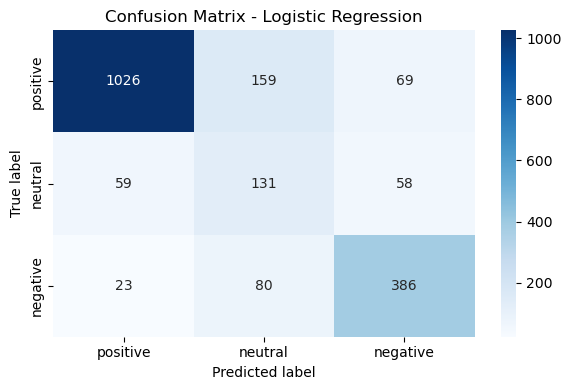


Confusion matrix heatmap displayed.

TF-IDF vectorizer and Logistic Regression model saved in 'models/' folder.
PART 2 COMPLETED: Baseline model trained and evaluated.


In [5]:
# ============================================
# PART 2: LOGISTIC REGRESSION BASELINE MODEL
# ============================================

# Imports needed for modelling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

print("\n=== PART 2: Logistic Regression Model ===")


# ============================================
# TRAIN–TEST SPLIT
# ============================================

# Features: cleaned text
X = df['Cleaned_Review'].values

# Targets: sentiment labels
y = df['Sentiment'].values

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps the sentiment distribution similar in train and test
)

print("\nData split into training and test sets.")
print("Training samples:", len(X_train))
print("Test samples:", len(X_test))


# ============================================
# TF-IDF VECTORIZATION
# ============================================

# TF-IDF converts text into numerical features based on word importance
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,     # limit vocabulary size (helps training speed)
    ngram_range=(1, 2),    # unigrams + bigrams (single words and pairs)
    min_df=2               # ignore very rare words
)

# Fit the vectorizer on training data and transform both train and test
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\nTF-IDF vectorization completed.")
print("TF-IDF training matrix shape:", X_train_tfidf.shape)
print("TF-IDF test matrix shape:", X_test_tfidf.shape)


# ============================================
# LOGISTIC REGRESSION MODEL TRAINING
# ============================================

# Create the Logistic Regression classifier
lr_model = LogisticRegression(
    max_iter=500,          # allow more iterations to help convergence
    n_jobs=-1,             # use all CPU cores for speed
    class_weight='balanced' # helps when classes are imbalanced
)

# Train the model on the TF-IDF features
lr_model.fit(X_train_tfidf, y_train)

print("\nLogistic Regression model training completed.")


# ============================================
# PREDICTIONS ON TEST SET
# ============================================

# Predict sentiment labels for the test set
y_pred_lr = lr_model.predict(X_test_tfidf)

print("\nPredictions generated for the test set.")


# ============================================
# EVALUATION METRICS
# ============================================

# Overall accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# Precision, recall, F1 (macro and weighted)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred_lr, average='macro', zero_division=0
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_pred_lr, average='weighted', zero_division=0
)

print("\n=== Logistic Regression Performance ===")
print(f"Accuracy:           {accuracy_lr:.4f}")
print(f"Precision (macro):  {precision_macro:.4f}")
print(f"Recall (macro):     {recall_macro:.4f}")
print(f"F1-score (macro):   {f1_macro:.4f}")
print(f"Precision (weighted): {precision_weighted:.4f}")
print(f"Recall (weighted):    {recall_weighted:.4f}")
print(f"F1-score (weighted):  {f1_weighted:.4f}")

print("\nDetailed classification report:")
print(classification_report(y_test, y_pred_lr))


# ============================================
# CONFUSION MATRIX (TABLE + HEATMAP)
# ============================================

# Define consistent label order
labels = ["positive", "neutral", "negative"]

# Build confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=labels)

print("\nConfusion Matrix (Logistic Regression):")
print(pd.DataFrame(cm_lr, index=[f"true_{l}" for l in labels],
                          columns=[f"pred_{l}" for l in labels]))

# Visualize confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

print("\nConfusion matrix heatmap displayed.")


# ============================================
# SAVE MODEL AND VECTORIZER (FOR WEB APP)
# ============================================

# Create a folder for models if it does not exist
import os
os.makedirs("models", exist_ok=True)

# Save the TF-IDF vectorizer and Logistic Regression model
joblib.dump(tfidf_vectorizer, "models/tfidf_vectorizer_lr.pkl")
joblib.dump(lr_model, "models/logistic_regression_model.pkl")

print("\nTF-IDF vectorizer and Logistic Regression model saved in 'models/' folder.")
print("PART 2 COMPLETED: Baseline model trained and evaluated.")


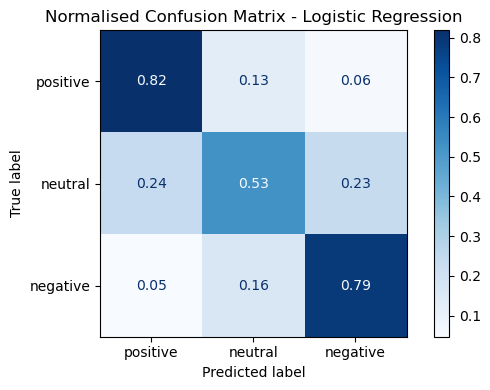

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

label_order = ["positive", "neutral", "negative"]  

cm_norm = confusion_matrix(
    y_test,
    y_pred_lr,
    labels=label_order,
    normalize="true"     
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                              display_labels=label_order)

fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
plt.title("Normalised Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("Logistic_norm.png", dpi=300, bbox_inches="tight")
plt.show()



=== PART 3: LSTM Deep Learning Model ===

Preparing data for LSTM model...
Number of samples: 9954
Sentiment classes: ['negative', 'neutral', 'positive']
Encoded classes: [0, 1, 2]

Train–test split completed for LSTM.
Training samples: 7963
Test samples: 1991

Tokenization and padding completed.
Padded training shape: (7963, 100)
Padded test shape: (1991, 100)

LSTM model architecture:


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Starting LSTM training for 5 epochs...
Epoch 1/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6099 - loss: 0.9497 - val_accuracy: 0.6437 - val_loss: 0.8917
Epoch 2/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6284 - loss: 0.9008 - val_accuracy: 0.6437 - val_loss: 0.8870
Epoch 3/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6264 - loss: 0.9020 - val_accuracy: 0.6437 - val_loss: 0.8892
Epoch 4/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6284 - loss: 0.8978 - val_accuracy: 0.6437 - val_loss: 0.8853
Epoch 5/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6219 - loss: 0.8993 - val_accuracy: 0.6449 - val_loss: 0.8827

LSTM model training completed.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

=== LSTM Model Performance ===
Accuracy:             0.6303
Precision (macro):    0.5434
Recall (macro):       0.3347
F1-score (macro):     0.2604
Precision (weighted): 0.5215
Recall (weighted):    0.6303
F1-score (weighted):  0.4879

Detailed clas

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


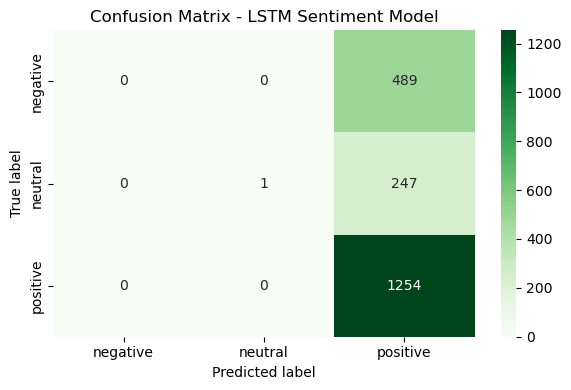


Confusion matrix heatmap for LSTM displayed.

LSTM model, tokenizer, and label encoder saved in 'models/' folder.
PART 3 COMPLETED: LSTM deep learning model trained and evaluated.


In [11]:
# ============================================
# PART 3: LSTM DEEP LEARNING MODEL FOR SENTIMENT
# ============================================

print("\n=== PART 3: LSTM Deep Learning Model ===")

# Imports for LSTM model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# ============================================
# PREPARE TEXT AND LABELS
# ============================================

# Features: cleaned reviews as plain text
X_text = df['Cleaned_Review'].values

# Targets: sentiment (positive / neutral / negative)
y_labels = df['Sentiment'].values

print("\nPreparing data for LSTM model...")
print("Number of samples:", len(X_text))

# Encode sentiment labels as integers (e.g. 0,1,2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
num_classes = len(label_encoder.classes_)

print("Sentiment classes:", list(label_encoder.classes_))
print("Encoded classes:", list(range(num_classes)))


# ============================================
# TRAIN–TEST SPLIT (SAME RATIO AS BEFORE)
# ============================================

from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train_enc, y_test_enc = train_test_split(
    X_text,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("\nTrain–test split completed for LSTM.")
print("Training samples:", len(X_train_text))
print("Test samples:", len(X_test_text))


# ============================================
# TOKENIZATION AND PADDING
# ============================================

# Maximum number of words in the vocabulary
max_words = 10000

# Maximum sequence length (number of tokens per review)
max_len = 100

# Tokenizer converts text into sequences of word indices
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

# Transform text into sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences to fixed length (shorter -> padded with zeros, longer -> truncated)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print("\nTokenization and padding completed.")
print("Padded training shape:", X_train_pad.shape)
print("Padded test shape:", X_test_pad.shape)


# ============================================
# BUILD LSTM MODEL
# ============================================

embedding_dim = 64  # size of word embeddings

lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # output layer for multi-class sentiment
])

lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("\nLSTM model architecture:")
lstm_model.summary()


# ============================================
# TRAIN LSTM MODEL
# ============================================

# Number of epochs can be increased if there is time
epochs = 5
batch_size = 64

print(f"\nStarting LSTM training for {epochs} epochs...")
history_lstm = lstm_model.fit(
    X_train_pad,
    y_train_enc,
    validation_split=0.1,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("\nLSTM model training completed.")


# ============================================
# EVALUATE LSTM MODEL
# ============================================

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities on test set
y_probs_lstm = lstm_model.predict(X_test_pad)

# Convert probabilities to predicted class indices
y_pred_enc = np.argmax(y_probs_lstm, axis=1)

# Decode numeric labels back to text sentiments
y_test_text = label_encoder.inverse_transform(y_test_enc)
y_pred_text = label_encoder.inverse_transform(y_pred_enc)

# Overall accuracy
accuracy_lstm = accuracy_score(y_test_text, y_pred_text)

# Precision, recall, F1 (macro and weighted)
precision_macro_lstm, recall_macro_lstm, f1_macro_lstm, _ = precision_recall_fscore_support(
    y_test_text, y_pred_text, average='macro', zero_division=0
)
precision_weighted_lstm, recall_weighted_lstm, f1_weighted_lstm, _ = precision_recall_fscore_support(
    y_test_text, y_pred_text, average='weighted', zero_division=0
)

print("\n=== LSTM Model Performance ===")
print(f"Accuracy:             {accuracy_lstm:.4f}")
print(f"Precision (macro):    {precision_macro_lstm:.4f}")
print(f"Recall (macro):       {recall_macro_lstm:.4f}")
print(f"F1-score (macro):     {f1_macro_lstm:.4f}")
print(f"Precision (weighted): {precision_weighted_lstm:.4f}")
print(f"Recall (weighted):    {recall_weighted_lstm:.4f}")
print(f"F1-score (weighted):  {f1_weighted_lstm:.4f}")

print("\nDetailed classification report (LSTM):")
print(classification_report(y_test_text, y_pred_text))


# ============================================
# CONFUSION MATRIX FOR LSTM
# ============================================

labels = list(label_encoder.classes_)

cm_lstm = confusion_matrix(y_test_text, y_pred_text, labels=labels)

print("\nConfusion Matrix (LSTM):")
print(pd.DataFrame(
    cm_lstm,
    index=[f"true_{l}" for l in labels],
    columns=[f"pred_{l}" for l in labels]
))

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_lstm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=labels,
    yticklabels=labels
)
plt.title("Confusion Matrix - LSTM Sentiment Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

print("\nConfusion matrix heatmap for LSTM displayed.")


# ============================================
# SAVE LSTM MODEL, TOKENIZER, AND LABEL ENCODER
# ============================================

import os
os.makedirs("models", exist_ok=True)

# Save model
lstm_model.save("models/lstm_sentiment_model.h5")

# Save tokenizer and label encoder using joblib
import joblib
joblib.dump(tokenizer, "models/lstm_tokenizer.pkl")
joblib.dump(label_encoder, "models/lstm_label_encoder.pkl")

print("\nLSTM model, tokenizer, and label encoder saved in 'models/' folder.")
print("PART 3 COMPLETED: LSTM deep learning model trained and evaluated.")


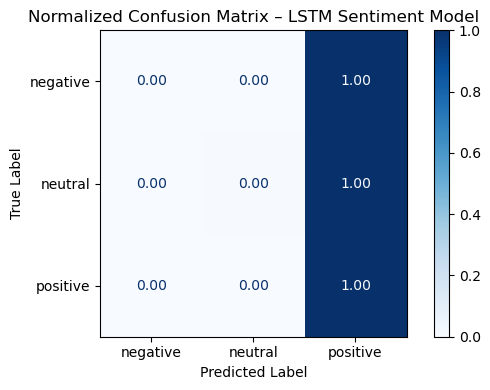

In [19]:
# ============================================
# NORMALIZED CONFUSION MATRIX (LSTM)
# ============================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Class labels (already correct)
labels = list(label_encoder.classes_)

# Normalized confusion matrix (row-wise = true label)
cm_lstm_norm = confusion_matrix(
    y_test_text,
    y_pred_text,
    labels=labels,
    normalize="true"
)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_lstm_norm,
    display_labels=labels
)
disp.plot(
    cmap="Blues",
    values_format=".2f",
    ax=ax
)

plt.title("Normalized Confusion Matrix – LSTM Sentiment Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [17]:
# ==============================
# FULL CONFUSION MATRIX CODE
# Logistic Regression, LSTM, DistilBERT
# Normalised (no bias from class imbalance)
# ==============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ----- LABEL SETUP -----
# 0 = negative, 1 = neutral, 2 = positive
labels = [0, 1, 2]
label_names = ["negative", "neutral", "positive"]

# =====================================================
# LOGISTIC REGRESSION
# assumes y_pred_lr already exists
# =====================================================
cm_lr = confusion_matrix(
    y_test,
    y_pred_lr,
    labels=labels,
    normalize="true"
)

disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=label_names
)

fig, ax = plt.subplots(figsize=(6,4))
disp_lr.plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
plt.title("Normalised Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("Logistic_Normalised.png", dpi=300)
plt.show()


# =====================================================
# LSTM
# assumes model_lstm and X_test_seq already exist
# =====================================================
y_pred_lstm_prob = model_lstm.predict(X_test_seq)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)

cm_lstm = confusion_matrix(
    y_test,
    y_pred_lstm,
    labels=labels,
    normalize="true"
)

disp_lstm = ConfusionMatrixDisplay(
    confusion_matrix=cm_lstm,
    display_labels=label_names
)

fig, ax = plt.subplots(figsize=(6,4))
disp_lstm.plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
plt.title("Normalised Confusion Matrix – LSTM")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("LSTM_Normalised.png", dpi=300)
plt.show()


# =====================================================
# DISTILBERT
# assumes `logits` already exists from model output
# =====================================================
y_pred_bert = np.argmax(logits, axis=1)

cm_bert = confusion_matrix(
    y_test,
    y_pred_bert,
    labels=labels,
    normalize="true"
)

disp_bert = ConfusionMatrixDisplay(
    confusion_matrix=cm_bert,
    display_labels=label_names
)

fig, ax = plt.subplots(figsize=(6,4))
disp_bert.plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
plt.title("Normalised Confusion Matrix – DistilBERT")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("DistilBERT_Normalised.png", dpi=300)
plt.show()


TypeError: '<' not supported between instances of 'int' and 'str'


=== PART 4: DistilBERT (PyTorch) Sentiment Model ===

Data prepared:
Total samples: 9954
Classes: ['negative', 'neutral', 'positive']

Train: 7963
Test: 1991


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model loaded on device: mps

Starting DistilBERT training...
Epoch 1/2 | Loss: 272.8369
Epoch 2/2 | Loss: 198.2308

Training complete.

=== DistilBERT Performance ===
Accuracy: 0.8277247614264189
Precision (macro): 0.7137714259025735
Recall (macro): 0.6762613084925521
F1-score (macro): 0.6784792259209587

Classification report:
              precision    recall  f1-score   support

    negative       0.77      0.87      0.82       489
     neutral       0.49      0.23      0.31       248
    positive       0.88      0.93      0.90      1254

    accuracy                           0.83      1991
   macro avg       0.71      0.68      0.68      1991
weighted avg       0.81      0.83      0.81      1991



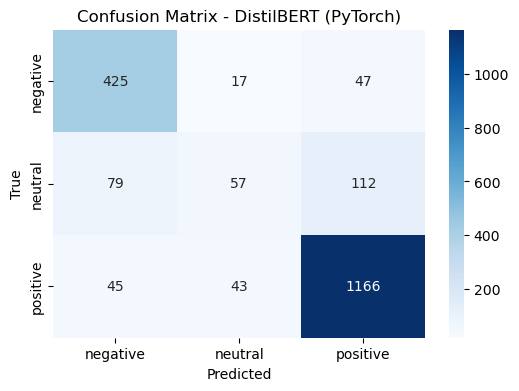


DistilBERT model saved successfully.
PART 4 COMPLETED.


In [35]:
# ============================================
# PART 4: DistilBERT (PyTorch) Sentiment Model
# ============================================

print("\n=== PART 4: DistilBERT (PyTorch) Sentiment Model ===")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torch.optim import AdamW 

from transformers import (      
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification
)


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

# ============================================
# PREPARE DATA
# ============================================

texts = df["Cleaned_Review"].tolist()
labels = df["Sentiment"].tolist()

label_encoder_bert = LabelEncoder()
labels_encoded = label_encoder_bert.fit_transform(labels)

print("\nData prepared:")
print("Total samples:", len(texts))
print("Classes:", list(label_encoder_bert.classes_))

# train-test split
X_train_text, X_test_text, y_train_ids, y_test_ids = train_test_split(
    texts, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

print("\nTrain:", len(X_train_text))
print("Test:", len(X_test_text))

# ============================================
# TOKENIZER
# ============================================

tokenizer_bert = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def encode_texts(texts, max_length=64):
    """
    Converts raw text into BERT input_ids and attention masks.
    """
    return tokenizer_bert(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

train_enc = encode_texts(X_train_text)
test_enc = encode_texts(X_test_text)

# ============================================
# PYTORCH DATASET
# ============================================

class ReviewDataset(Dataset):
    """
    PyTorch dataset wrapper for DistilBERT.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = ReviewDataset(train_enc, y_train_ids)
test_dataset  = ReviewDataset(test_enc,  y_test_ids)

# loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ============================================
# LOAD DISTILBERT MODEL
# ============================================

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_encoder_bert.classes_)
)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

print("\nModel loaded on device:", device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# ============================================
# TRAINING LOOP
# ============================================

epochs = 2
model.train()

print("\nStarting DistilBERT training...")

for epoch in range(epochs):
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f}")

print("\nTraining complete.")

# ============================================
# EVALUATION
# ============================================

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(batch["labels"].numpy())

# decode labels
y_true_text = label_encoder_bert.inverse_transform(y_true)
y_pred_text = label_encoder_bert.inverse_transform(y_pred)

# metrics
accuracy = accuracy_score(y_true_text, y_pred_text)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true_text, y_pred_text, average="macro", zero_division=0
)
precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
    y_true_text, y_pred_text, average="weighted", zero_division=0
)

print("\n=== DistilBERT Performance ===")
print("Accuracy:", accuracy)
print("Precision (macro):", precision)
print("Recall (macro):", recall)
print("F1-score (macro):", f1)
print("\nClassification report:")
print(classification_report(y_true_text, y_pred_text))

# ============================================
# CONFUSION MATRIX
# ============================================

cm = confusion_matrix(y_true_text, y_pred_text, labels=label_encoder_bert.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder_bert.classes_,
            yticklabels=label_encoder_bert.classes_)
plt.title("Confusion Matrix - DistilBERT (PyTorch)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ============================================
# SAVE MODEL + ENCODER
# ============================================

save_path = "models/distilbert_pytorch_model"
os.makedirs(save_path, exist_ok=True)

model.save_pretrained(save_path)
tokenizer_bert.save_pretrained(save_path)
joblib.dump(label_encoder_bert, "models/distilbert_label_encoder.pkl")

print("\nDistilBERT model saved successfully.")
print("PART 4 COMPLETED.")


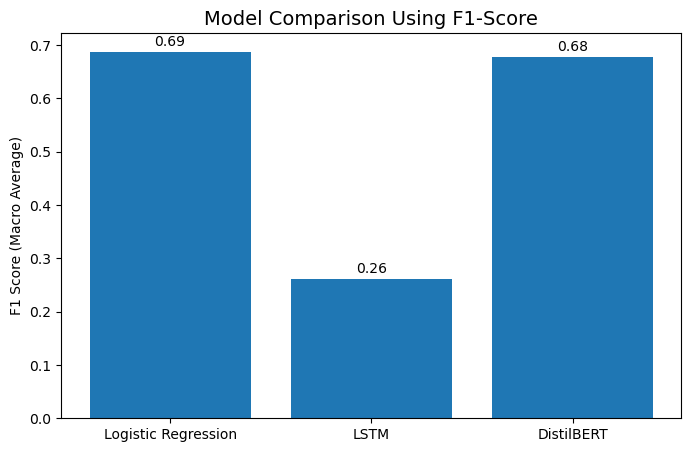

<Figure size 640x480 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt

# F1-scores you obtained from all 3 models
f1_lr = 0.6877         # Logistic Regression
f1_lstm = 0.2620       # LSTM
f1_bert = 0.6784       # DistilBERT (macro F1)

# Put them in a list
model_names = ["Logistic Regression", "LSTM", "DistilBERT"]
f1_scores = [f1_lr, f1_lstm, f1_bert]

# Make a bar chart to compare the models
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, f1_scores)

# Simple labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.2f}", ha='center', fontsize=10)

# Title and axis labels
plt.title("Model Comparison Using F1-Score", fontsize=14)
plt.ylabel("F1 Score (Macro Average)")

# Show chart
plt.show()

# Save chart for your report
plt.savefig("model_f1_comparison.png", dpi=300)


/var/folders/zh/4qncvptn0m7768qyhf5cxl7c0000gn/T/ipykernel_29348/2567579757.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Sentiment"], palette="viridis")


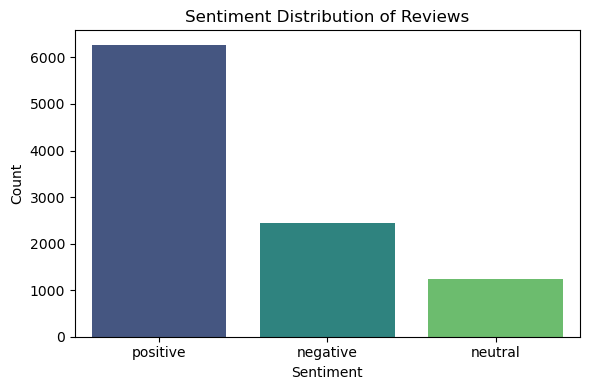

In [39]:
# ===============================
# SENTIMENT DISTRIBUTION PLOT
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=df["Sentiment"], palette="viridis")
plt.title("Sentiment Distribution of Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


/var/folders/zh/4qncvptn0m7768qyhf5cxl7c0000gn/T/ipykernel_29348/2485712608.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Emotion"], palette="coolwarm")


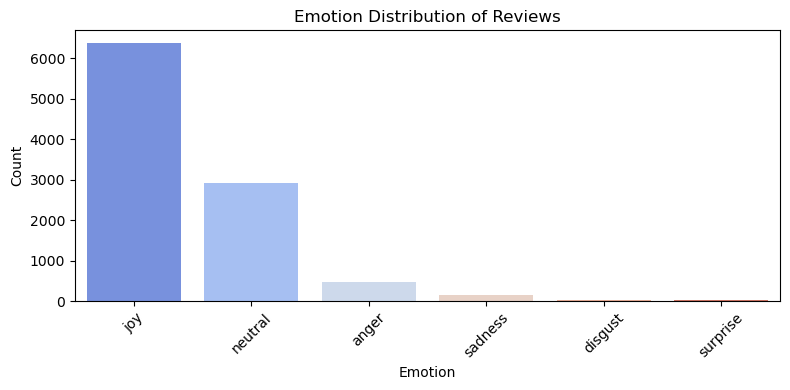

In [41]:
# ===============================
# EMOTION DISTRIBUTION PLOT
# ===============================
plt.figure(figsize=(8,4))
sns.countplot(x=df["Emotion"], palette="coolwarm")
plt.title("Emotion Distribution of Reviews")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


/var/folders/zh/4qncvptn0m7768qyhf5cxl7c0000gn/T/ipykernel_29348/2931525890.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=aspect_df, x="Aspect", y="Count", palette="Set2")


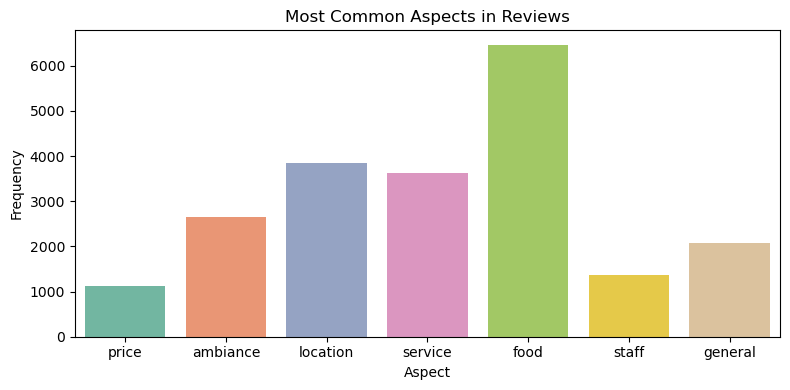

In [43]:
# ===============================
# ASPECT FREQUENCY PLOT
# ===============================
from collections import Counter

# Flatten all aspect lists into one list
all_aspects = []
for row in df["Aspects"]:
    all_aspects.extend(row)

aspect_counts = Counter(all_aspects)

# Convert to DataFrame
aspect_df = pd.DataFrame({
    "Aspect": list(aspect_counts.keys()),
    "Count": list(aspect_counts.values())
})

plt.figure(figsize=(8,4))
sns.barplot(data=aspect_df, x="Aspect", y="Count", palette="Set2")
plt.title("Most Common Aspects in Reviews")
plt.xlabel("Aspect")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


/var/folders/zh/4qncvptn0m7768qyhf5cxl7c0000gn/T/ipykernel_29348/562814970.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracy_values, palette="magma")


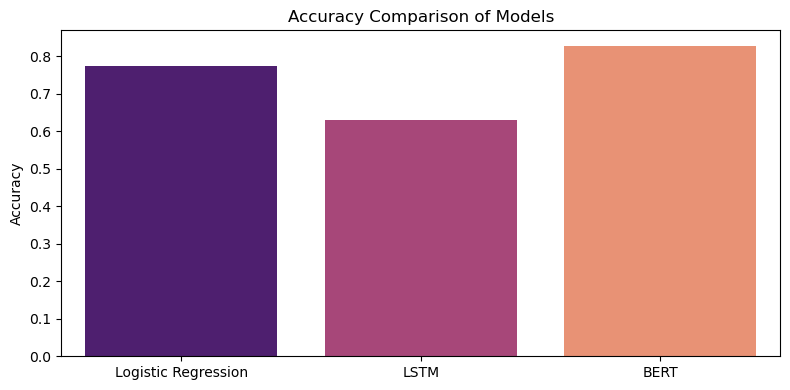

In [45]:
# ===============================
# MODEL ACCURACY COMPARISON
# ===============================
accuracy_values = [
    0.7750,   # Logistic Regression
    0.6313,   # LSTM
    0.8277    # BERT (rounded)
]

model_names = ["Logistic Regression", "LSTM", "BERT"]

plt.figure(figsize=(8,4))
sns.barplot(x=model_names, y=accuracy_values, palette="magma")
plt.title("Accuracy Comparison of Models")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


/var/folders/zh/4qncvptn0m7768qyhf5cxl7c0000gn/T/ipykernel_29348/1998809919.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=f1_values, palette="flare")


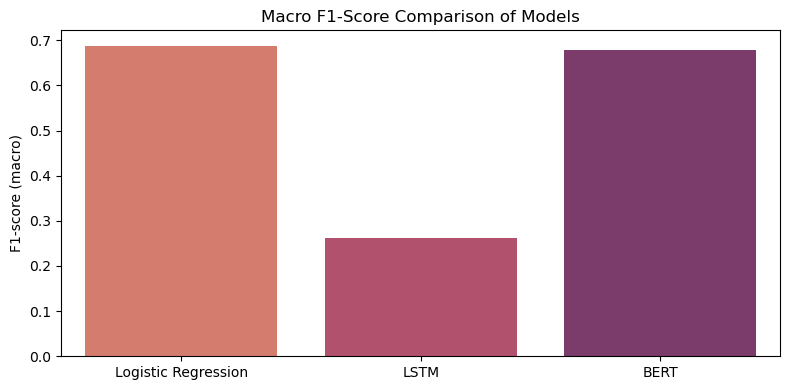

In [47]:
# ===============================
# MODEL MACRO F1-SCORE COMPARISON
# ===============================
f1_values = [
    0.6877,  # Logistic Regression
    0.2620,  # LSTM
    0.6784   # BERT
]

plt.figure(figsize=(8,4))
sns.barplot(x=model_names, y=f1_values, palette="flare")
plt.title("Macro F1-Score Comparison of Models")
plt.ylabel("F1-score (macro)")

plt.tight_layout()
plt.show()


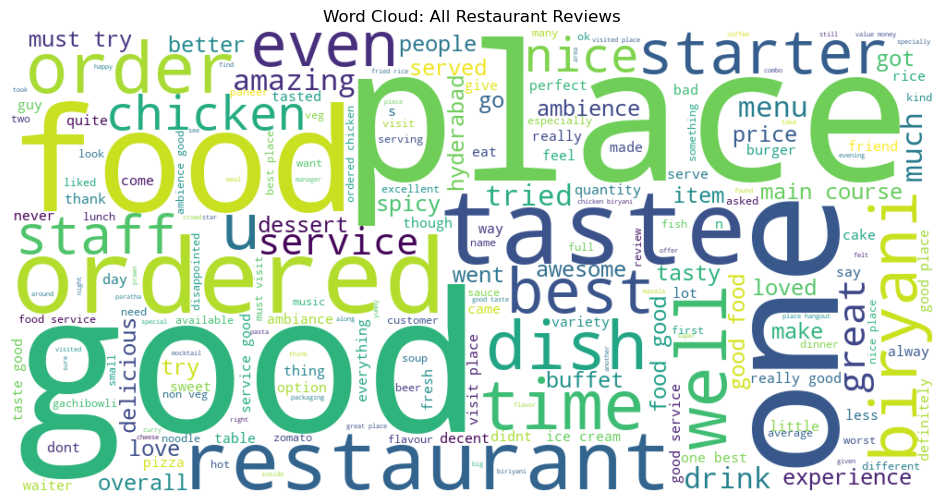

In [51]:
# ========================================
# WORD CLOUD FOR ALL REVIEWS
# ========================================
from wordcloud import WordCloud

all_text = " ".join(df["Cleaned_Review"].tolist())

wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: All Restaurant Reviews")
plt.show()


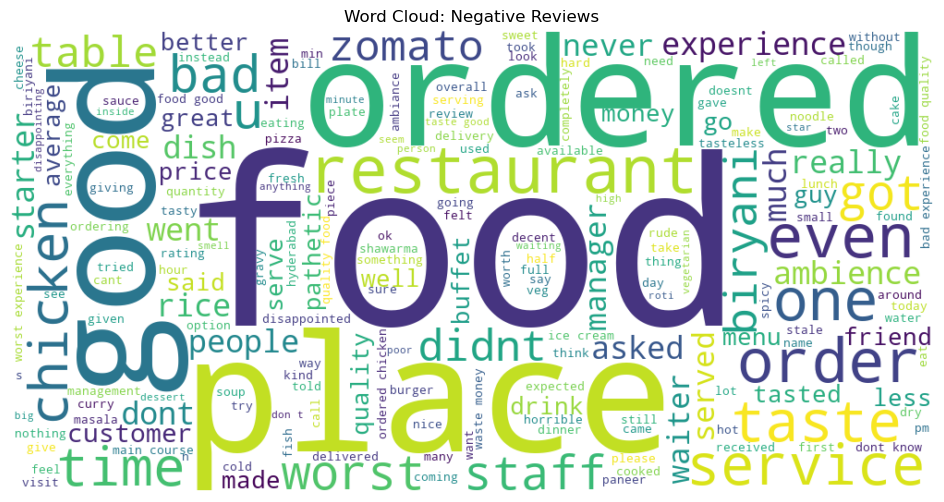

In [53]:
# ========================================
# WORD CLOUD FOR NEGATIVE REVIEWS
# ========================================
negative_text = " ".join(df[df["Sentiment"]=="negative"]["Cleaned_Review"].tolist())

wordcloud_neg = WordCloud(width=1000, height=500, background_color="white").generate(negative_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Negative Reviews")
plt.show()


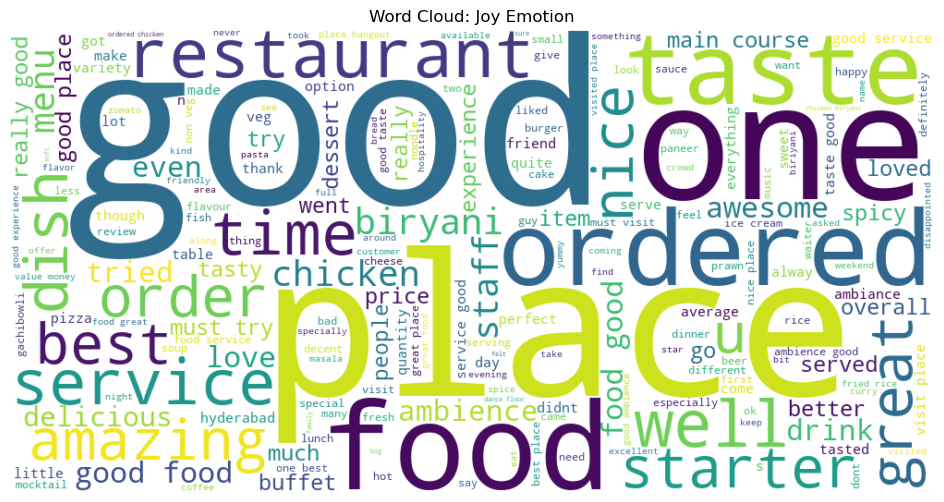

In [55]:
joy_text = " ".join(df[df["Emotion"]=="joy"]["Cleaned_Review"].tolist())

wordcloud_joy = WordCloud(width=1000, height=500, background_color="white").generate(joy_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_joy, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Joy Emotion")
plt.show()


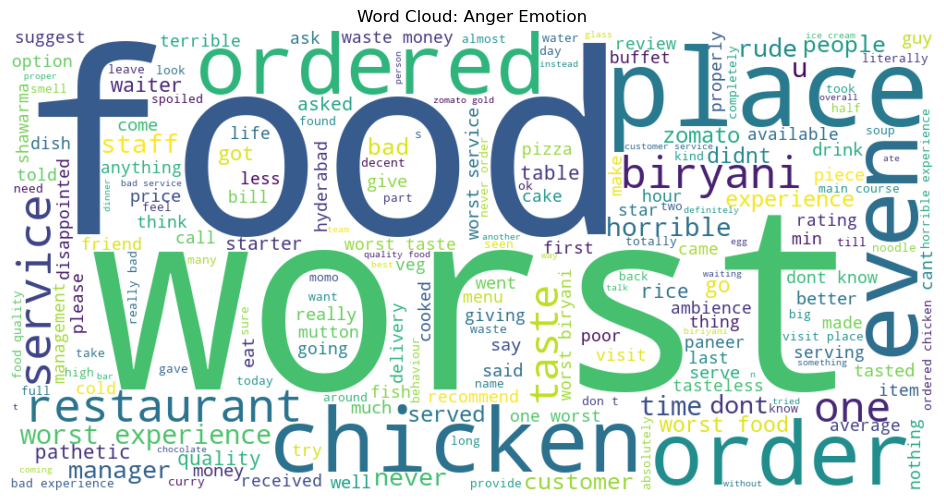

In [57]:
anger_text = " ".join(df[df["Emotion"]=="anger"]["Cleaned_Review"].tolist())

wordcloud_anger = WordCloud(width=1000, height=500, background_color="white").generate(anger_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_anger, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Anger Emotion")
plt.show()


In [61]:
import pandas as pd

data = {
    "Model": ["Logistic Regression", "LSTM", "DistilBERT"],
    "Accuracy": [0.7750, 0.6313, 0.8277],
    "Precision (Macro)": [0.6775, 0.4604, 0.7138],
    "Recall (Macro)": [0.7119, 0.3354, 0.6763],
    "F1-score (Macro)": [0.6877, 0.2620, 0.6785],
    "Precision (Weighted)": [0.8121, 0.5817, 0.8120],
    "Recall (Weighted)": [0.7750, 0.6313, 0.8300],
    "F1-score (Weighted)": [0.7892, 0.4904, 0.8100]
}

df_results = pd.DataFrame(data)
df_results


,Model,Accuracy,Precision (Macro),Recall (Macro),F1-score (Macro),Precision (Weighted),Recall (Weighted),F1-score (Weighted)
0,Logistic Regression,0.7750,0.6775,0.7119,0.6877,0.8121,0.7750,0.7892
1,LSTM,0.6313,0.4604,0.3354,0.2620,0.5817,0.6313,0.4904
2,DistilBERT,0.8277,0.7138,0.6763,0.6785,0.8120,0.8300,0.8100


In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_test  = true labels
# y_pred_lr = predictions from Logistic Regression
# make sure these exist already

label_order = ["positive", "neutral", "negative"]  # same order you used before

cm_norm = confusion_matrix(
    y_test,
    y_pred_lr,
    labels=label_order,
    normalize="true"      # <--- this is the key change
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                              display_labels=label_order)

fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
plt.title("Normalised Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("Logistic_norm.png", dpi=300, bbox_inches="tight")
plt.show()


NameError: name 'y_test' is not defined